In [1]:
import pandas as pd
import numpy as np
import os
import requests
import time


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load
from scipy import stats

from category_encoders import CountEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from math import log2, ceil

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
telegram_api_token = os.getenv("telegram_api_token")
telegram_chat_id = os.getenv("telegram_chat_id")


def notify(text="Execution completed."):
    if telegram_api_token and telegram_chat_id:
        requests.post(
            "https://api.telegram.org/"
            + "bot{}/sendMessage".format(telegram_api_token),
            params=dict(chat_id=telegram_chat_id, text=text),
        )
    else:
        pass


def get_results(gs, features_of_interest=None, round=2):
    results = {
        key: gs.cv_results_[key]
        for key in [
            "mean_fit_time",
            "std_fit_time",
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
            "params",
        ]
    }
    results_df = pd.DataFrame(
        {
            "model": [type(params["model"]).__name__ for params in results["params"]],
            "preprocessing": [
                getattr(params["preprocessing"], "name") for params in results["params"]
            ],
            **results,
        }
    )
    results_df = results_df.round(round)

    if features_of_interest:
        for key, col_name in features_of_interest.items():
            results_df[col_name] = results_df["params"].apply(lambda x: x.get(key))
        results_df = results_df.drop("params", axis=1)

    return results_df


def custom_mutual_info_classif(X, y):
    return mutual_info_classif(X, y, n_neighbors=35)

In [4]:
train = pd.read_csv("./resources/train_data.csv", low_memory=False)

test = pd.read_csv("./resources/test_data.csv")

In [5]:
# Drop duplicates
train = train.drop_duplicates()

# Define Claim Identifier as the index
train.set_index("Claim Identifier", inplace=True)
test.set_index("Claim Identifier", inplace=True)

# Drop rows that have missing values in the target
train = train.dropna(subset=["Claim Injury Type"])

# Drop cols that are not on test dataset
train = train.drop(columns=["Agreement Reached", "WCB Decision"])

In [6]:
cause_injury = {
    "I. Burn or Scald - Heat or Cold Exposures - Contact With": [
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "11",
        "14",
        "84",
    ],
    "II. Caught In, Under or Between": ["10", "12", "13", "20"],
    "III. Cut, Puncture, Scrape Injured By": ["15", "16", "17", "18", "19"],
    "IV. Fall, Slip or Trip Injury": [
        "25",
        "26",
        "27",
        "28",
        "29",
        "30",
        "31",
        "32",
        "33",
    ],
    "V. Motor Vehicle": ["40", "41", "45", "46", "47", "48", "50"],
    "VI. Strain or Injury By": [
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "58",
        "59",
        "60",
        "61",
        "97",
    ],
    "VII. Striking Against or Stepping On": [
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
    ],
    "VIII. Struck or Injured By": [
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "81",
        "85",
        "86",
    ],
    "IX. Rubbed or Abraded By": ["94", "95"],
    "X. Miscellaneous Causes": [
        "82",
        "83",
        "87",
        "88",
        "89",
        "90",
        "91",
        "93",
        "96",
        "98",
        "99",
    ],
}

nature_injury = {
    "specific_injury": [
        "1",
        "2",
        "3",
        "4",
        "7",
        "10",
        "13",
        "16",
        "19",
        "22",
        "25",
        "28",
        "30",
        "31",
        "32",
        "34",
        "36",
        "37",
        "38",
        "40",
        "41",
        "42",
        "43",
        "46",
        "47",
        "49",
        "52",
        "53",
        "54",
        "55",
        "58",
        "59",
    ],
    "occupational_disease": [
        "60",
        "61",
        "62",
        "63",
        "64",
        "65",
        "66",
        "67",
        "68",
        "69",
        "70",
        "71",
        "72",
        "73",
        "74",
        "75",
        "76",
        "77",
        "78",
        "79",
        "80",
        "83",
    ],
    "multiple_injuries": ["90", "91"],
}
body_part = {
    "head": [
        "10",
        "11",
        "12",
        "13",
        "13A",
        "13B",
        "13C",
        "14",
        "14A",
        "14B",
        "14C",
        "15",
        "16",
        "17",
        "18",
        "19",
    ],
    "neck": ["20", "21", "22", "23", "24", "25", "26"],
    "upper_extremities": [
        "30",
        "31",
        "32",
        "33",
        "34",
        "35",
        "36",
        "36A",
        "36B",
        "36C",
        "36D",
        "36E",
        "36F",
        "36G",
        "36H",
        "36I",
        "36J",
        "36K",
        "36L",
        "36M",
        "36N",
        "36O",
        "36P",
        "37",
        "37A",
        "37B",
        "37C",
        "38",
        "39",
    ],
    "trunk": [
        "40",
        "41",
        "42",
        "43",
        "44",
        "45",
        "46",
        "47",
        "48",
        "49",
        "60",
        "61",
        "62",
        "63",
    ],
    "lower_extremities": [
        "50",
        "51",
        "52",
        "53",
        "54",
        "55",
        "56",
        "57",
        "57A",
        "57B",
        "57C",
        "57D",
        "57E",
        "57F",
        "57G",
        "58",
        "58A",
        "58B",
        "58C",
    ],
    "multiple_body_parts": ["64", "65", "66", "90", "91", "99"],
}

In [7]:
missing_dict = {
    col: round(train[col].isna().sum() * 100 / len(train), 2) for col in train.columns
}

missing_df = pd.DataFrame(
    list(missing_dict.items()), columns=["Column", "Missing Percentage"]
)

missing_df[missing_df["Missing Percentage"] > 50].sort_values(
    by="Missing Percentage", ascending=False
)

,Column,Missing Percentage
21,OIICS Nature of Injury Description,100.00
17,IME-4 Count,76.86
15,First Hearing Date,73.73
8,C-3 Date,67.38


In [8]:
# Independent variables
X = train.drop(["Claim Injury Type"], axis=1)

# Dependent variable
y = train[["Claim Injury Type"]]
y = y.to_numpy().ravel()

In [16]:
# Numeric columns
num_cols = [
    "Age at Injury",
    "Average Weekly Wage",
    "Birth Year",
    "IME-4 Count",
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]

# Categorical columns
cat_cols = [
    "Carrier Name",
    "County of Injury",
    "Medical Fee Region",
    "Industry Code",
    "Industry Code Description",
    "District Name",
    "WCIO Cause of Injury Code",
    "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Code",
    "WCIO Nature of Injury Description",
    "WCIO Part Of Body Code",
    "WCIO Part Of Body Description",
    "Zip Code",
    "OIICS Nature of Injury Description",
    "Accident Date",
]

# Binary columns
bin_cols = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "COVID-19 Indicator",
    "Gender",
    "Accident Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
    "Assembly Date",
    "Age at Injury",
]

# Preprocessing Pipeline

## Custom Classes

In [10]:
# _______________________NUM PIPELINE_______________________
class MissingValueImputer_Numeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Filling Missing values.
        """
        X = X.copy()

        # Birth Year or Age at Injury are NA
        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        # Extract the year from 'Accident Date' for later computations
        X["Accident Year"] = X["Accident Date"].dt.year
        # Imputing calculated Birth Year / Age at Injury
        X.loc[(X["Birth Year"].isna()) & (X["Age at Injury"].notna()), "Birth Year"] = (
            X["Accident Year"] - X["Age at Injury"]
        )
        X.loc[
            (X["Age at Injury"].isna()) & (X["Birth Year"].notna()), "Age at Injury"
        ] = (X["Accident Year"] - X["Birth Year"])
        # Drop the 'Accident Year' column after computation
        X.drop(columns=["Accident Year"], inplace=True)

        # After verifying that there where no zeros in IME-4 Count, it was concluded that NAs most likely represented zeros
        X["IME-4 Count"] = X["IME-4 Count"].fillna(0)

        # Most missing values in dates seem to be meaningful, as they likely mean the event never occured. In order to preserve their meaning, we will fill them with a clearly invalid future placeholder.
        X["First Hearing Date"] = X["First Hearing Date"].fillna(
            pd.Timestamp("2100-01-01")
        )
        X["C-2 Date"] = X["C-2 Date"].fillna(pd.Timestamp("2100-01-01"))

        return X


class AnomalyFixer_Numeric(BaseEstimator, TransformerMixin):
    """
    Transformer to handle anomalies such as zero or invalid values in columns like 'Age at Injury' and 'Birth Year'.
    """

    def __init__(self):
        self.medians = {}

    def fit(self, X, y=None):
        """
        Fit the transformer by computing median values for anomaly correction.
        """
        X = X.copy()

        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")

        # Calculate medians for date correction
        for col in ["C-2 Date", "C-3 Date", "Assembly Date", "First Hearing Date"]:
            X[col] = pd.to_datetime(X[col], errors="coerce")
            self.medians[col] = X[col].median()

        return self

    def transform(self, X):
        """
        Transform the data by fixing anomalies such as zeros in 'Age at Injury' and 'Birth Year'.
        """
        X = X.copy()

        # Birth Year or Age at Injury are equal to zero
        # Ensure 'Accident Date' is in datetime format
        X["Accident Date"] = pd.to_datetime(X["Accident Date"], errors="coerce")
        # Extract the year from 'Accident Date' for later computations
        X["Accident Year"] = X["Accident Date"].dt.year
        # Imputing calculated Birth Year / Age at Injury
        X.loc[(X["Birth Year"] == 0) & (X["Age at Injury"] != 0), "Birth Year"] = (
            X["Accident Year"] - X["Age at Injury"]
        )
        X.loc[(X["Age at Injury"] == 0) & (X["Birth Year"] != 0), "Age at Injury"] = (
            X["Accident Year"] - X["Birth Year"]
        )
        # Drop the 'Accident Year' column after computation
        X.drop(columns=["Accident Year"], inplace=True)

        # Fixing cases where Accident Date happens after other dates
        for col in ["C-2 Date", "C-3 Date", "Assembly Date", "First Hearing Date"]:
            X[col] = pd.to_datetime(X[col], errors="coerce")
            condition = (X[col] - X["Accident Date"]).dt.days < 0
            X.loc[condition, col] = self.medians[col]

        return X


class Num_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        date_columns=[
            "Accident Date",
            "Assembly Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
        ],
        birth_column="Birth Year",
        weekly_wage_column="Average Weekly Wage",
    ):
        """
        Transformer to process both date columns and numeric features.

        This class combines date processing (calculating date-based features) and numeric feature engineering
        (calculating features like age, age interactions, etc.) into one step.

        Parameters:
        ----------
        - date_columns: list of str
            List of columns containing date data to be processed.
        - birth_column: str, default="Birth Year"
            The column name containing the birth year of individuals.
        - weekly_wage_column: str, default="Average Weekly Wage"
            The column name for average weekly wage to be used in feature interactions.
        """
        self.date_columns = date_columns
        self.birth_column = birth_column
        self.weekly_wage_column = weekly_wage_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Step 1: Convert date columns to datetime and calculate date-based features
        for col in self.date_columns:
            X[col] = pd.to_datetime(X[col])

        X["Accident to Assembly Days"] = (
            X["Assembly Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to First Hearing Days"] = (
            X["First Hearing Date"] - X["Accident Date"]
        ).dt.days
        X["Accident to C-2 Days"] = (X["C-2 Date"] - X["Accident Date"]).dt.days
        X["Accident to C-3 Days"] = (X["C-3 Date"] - X["Accident Date"]).dt.days

        # Step 2: Generate additional numeric features based on birth year and other columns
        current_year = pd.Timestamp.now().year
        X["Age"] = current_year - X[self.birth_column]

        # Create year, month, and quarter features from 'Accident Date'
        X["Accident Year"] = X["Accident Date"].dt.year
        X["Accident Month"] = X["Accident Date"].dt.month
        X["Accident Quarter"] = X["Accident Date"].dt.quarter

        # Additional transformations using Age
        X["Relative Age at Injury"] = X["Age"] - X["Age at Injury"]
        X["Age Squared"] = X["Age"] ** 2
        X["Age x Weekly Wage"] = X["Age"] * X[self.weekly_wage_column]

        # Drop the original date columns after transformation
        X = X.drop(self.date_columns, axis=1)

        return X



class OutlierCapper(BaseEstimator, TransformerMixin):

    """
    Transformer to cap outliers in a DataFrame.
    Can use IQR or percentile method.

    Parameters:
    ----------
    method : str, optional (default="iqr")
        The method to use for outlier capping. Options are:
        - "iqr": Use the Interquartile Range (IQR) to define caps.
        - "percentile": Use lower and upper percentiles to define caps.

    lower_quantile : float, optional (default=0.01)
        The lower quantile for capping when using the "percentile" method.
    upper_quantile : float, optional (default=0.99)
        The upper quantile for capping when using the "percentile" method.
    iqr_multiplier : float, optional (default=1.5)
        The multiplier for the IQR to define caps when using the "iqr" method.







    Returns:
    ----------
    - DataFrame : The transformed DataFrame with the values capped.
    """


    def __init__(
        self, method="iqr", lower_quantile=0.01, upper_quantile=0.99, iqr_multiplier=1.5
    ):

        self.method = method
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.iqr_multiplier = iqr_multiplier


    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        self.caps_ = {}


        for col in X.columns:
            if self.method == "iqr":
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_cap = Q1 - self.iqr_multiplier * IQR
                upper_cap = Q3 + self.iqr_multiplier * IQR

            elif self.method == "percentile":
                lower_cap = X[col].quantile(self.lower_quantile)
                upper_cap = X[col].quantile(self.upper_quantile)

            self.caps_[col] = (lower_cap, upper_cap)
        return self


    def transform(self, X):
        X = pd.DataFrame(X)
        for col in X.columns:
            lower_cap, upper_cap = self.caps_[col]
            X[col] = X[col].clip(lower=lower_cap, upper=upper_cap)
        return X



# _______________________CATEGORICAL PIPELINE_______________________



class Categorical_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        columns_to_modify=[

            "WCIO Cause of Injury Code",
            "WCIO Nature of Injury Code",
            "WCIO Part Of Body Code",
        ],
        dict_mappings=[cause_injury, nature_injury, body_part],
    ):
        """
        Transformer to group code features into supra codes.
        Drops the original date columns.


        Parameters:
        ----------
        - columns_to_modify: lst of str, optional(default=["WCIO Cause of Injury Code", "WCIO Nature of Injury Code","WCIO Part Of Body Code"])
        List of columns with date data to be grouped.

        - dict_mappings: lst of dict, optional(default=[cause_injury, nature_injury, body_part])
        List of dictionaries mapping codes to supra codes.


        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original columns.
        """


        self.columns_to_modify = columns_to_modify

        self.dict_mappings = dict_mappings


    def fit(self, X, y=None):
        return self


    def transform(self, X):

        X = X.copy()

        if not isinstance(X, pd.DataFrame):

            X = pd.DataFrame(X)


        # CAUSE OF INJURY

        code_to_category = {
            code: category for category, codes in cause_injury.items() for code in codes
        }


        X["WCIO Cause of Injury Code SUPRA"] = X["WCIO Cause of Injury Code"].apply(
            lambda code: code_to_category.get(str(code).split(".")[0], np.nan)
        )


        # NATURE OF INJURY

        nature_code_to_category = {
            code: category
            for category, codes in {
                "Specific Injury": nature_injury["specific_injury"],
                "Occupational Disease or Cumulative Injury": nature_injury[
                    "occupational_disease"

                ],
                "Multiple Injuries": nature_injury["multiple_injuries"],
            }.items()
            for code in codes

        }


        X["WCIO Nature of Injury Code SUPRA"] = X["WCIO Nature of Injury Code"].apply(
            lambda code: nature_code_to_category.get(str(code).split(".")[0], np.nan)
        )


        # PART OF BODY

        body_part_to_category = {
            code: category
            for category, codes in {
                "Head": body_part["head"],
                "Neck": body_part["neck"],
                "Upper Extremities": body_part["upper_extremities"],
                "Trunk": body_part["trunk"],
                "Lower Extremities": body_part["lower_extremities"],
                "Multiple Body Parts": body_part["multiple_body_parts"],
            }.items()
            for code in codes

        }


        X["WCIO Part Of Body Code SUPRA"] = X["WCIO Part Of Body Code"].apply(
            lambda code: body_part_to_category.get(str(code).split(".")[0], np.nan)
        )


        return X.drop(self.columns_to_modify, axis=1)



# _______________________BINARY PIPELINE_______________________



class Binary_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        columns=[
            "Gender",
            "Alternative Dispute Resolution",
            "Attorney/Representative",
            "COVID-19 Indicator",
            "Accident Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
            "Assembly Date",
            "Age at Injury",
        ],
    ):
        """
        Transformer to calculate new binary features.
        Drops the original non binary columns.


        Parameters:
        ----------
        - columns: lst of str, required
        List of columns to be used during feature engineering.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original non binary.
        """
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert to Binary
        X["Male"] = np.select(
            [
                X["Gender"] == "M",
                X["Gender"] == "F",
                X["Gender"] == "X",
                X["Gender"] == "U",
            ],
            [1, 0, 0, 0],
        )

        convert_to_binary_cols = [
            "Alternative Dispute Resolution",
            "Attorney/Representative",
            "COVID-19 Indicator",
        ]
        for col in convert_to_binary_cols:
            X[col] = np.select(
                [
                    X[col] == "Y",
                    X[col] == "N",
                    ~X[col].isin(["Y", "N"]),
                ],
                [1, 0, np.nan],
            )

        # Convert columns to datetime
        date_columns = [
            "Accident Date",
            "C-2 Date",
            "C-3 Date",
            "First Hearing Date",
            "Assembly Date",
        ]
        for col in date_columns:
            X[col] = pd.to_datetime(
                X[col], errors="coerce"
            )  # Convert to datetime, coercing invalid values to NaT

        # Missing Date Flags (Assembly Date is never missing)
        for col in ["Accident Date", "C-2 Date", "C-3 Date", "First Hearing Date"]:
            X[f"Is Missing {col}"] = X[col].isna().astype(int)

        # Is weekend features (First Hearing Date is never in the weekend)
        X[" Is Weekend Accident Date"] = (
            X["Accident Date"].dt.weekday.isin([5, 6]).astype(int)
        )
        X["Is Weekend C-2 Date"] = X["C-2 Date"].dt.weekday.isin([5, 6]).astype(int)
        X["Is Weekend C-3 Date"] = X["C-3 Date"].dt.weekday.isin([5, 6]).astype(int)
        X["Is Weekend Assembly Date"] = (
            X["Assembly Date"].dt.weekday.isin([5, 6]).astype(int)
        )

        # Create the binary flag Accident Dates during COVID years
        covid_start = pd.Timestamp("2020-01-01")
        covid_end = pd.Timestamp("2022-12-31")
        X["Is COVID Accident Date"] = (
            X["Accident Date"].between(covid_start, covid_end).astype(int)
        )

        # Age Features
        # Create binary flag "Is Worker Under 30"
        X["Is Worker Under 30"] = (X["Age at Injury"] < 30).astype(int)

        # Create binary flag "Is Worker Over 50"
        X["Is Worker Over 50"] = (X["Age at Injury"] > 50).astype(int)

        # Dropping non-binary features
        return X.drop(
            columns=[
                "Accident Date",
                "C-2 Date",
                "C-3 Date",
                "Assembly Date",
                "First Hearing Date",
                "Age at Injury",
                "Gender",
            ],
            axis=1,
        )

In [ ]:
# The american Zip Codes' first digit provides info about the region where the person lives. So, we decided to create this function that later, in the pipeline, will access to which regions the american Zip Codes belong to (using the american Zip Codes database)
us_zips = pd.read_csv("zip_code_database.csv")


def transform_zip(zip_code):
    zip_code_str = str(zip_code)
    if (
        len(zip_code_str) < 5
        or zip_code_str.startswith("1")
        or zip_code_str.startswith("2")
        or zip_code_str.startswith("3")
        or zip_code_str.startswith("4")
    ):
        return "Eastern"
    elif (
        (zip_code_str.startswith("5"))
        | (zip_code_str.startswith("6"))
        | (zip_code_str.startswith("7"))
        | (zip_code_str.startswith("8"))
    ):
        return "Central"
    elif zip_code_str.startswith("9"):
        return "Western"


class Categorical_Feature_Engineering(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        columns_to_modify=[
            "WCIO Cause of Injury Code",
            "WCIO Nature of Injury Code",
            "WCIO Part Of Body Code",
            "Zip Code",
            "Accident Date",
        ],
        dict_mappings=[cause_injury, nature_injury, body_part],
    ):
        """
        Transformer to group code features into supra codes.
        Drops the original date columns.

        Parameters:
        ----------
        - columns_to_modify: lst of str, optional(default=["WCIO Cause of Injury Code", "WCIO Nature of Injury Code","WCIO Part Of Body Code"])
        List of columns with date data to be grouped.
        - dict_mappings: lst of dict, optional(default=[cause_injury, nature_injury, body_part])
        List of dictionaries mapping codes to supra codes.

        Returns:
        ----------
        - DataFrame : The transformed DataFrame with the new features and without the original columns.
        """

        self.columns_to_modify = columns_to_modify
        self.dict_mappings = dict_mappings

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # CAUSE OF INJURY
        code_to_category = {
            code: category for category, codes in cause_injury.items() for code in codes
        }
        X["WCIO Cause of Injury Code SUPRA"] = X["WCIO Cause of Injury Code"].apply(
            lambda code: code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # NATURE OF INJURY

        nature_code_to_category = {
            code: category
            for category, codes in {
                "Specific Injury": nature_injury["specific_injury"],
                "Occupational Disease or Cumulative Injury": nature_injury[
                    "occupational_disease"
                ],
                "Multiple Injuries": nature_injury["multiple_injuries"],
            }.items()
            for code in codes
        }

        X["WCIO Nature of Injury Code SUPRA"] = X["WCIO Nature of Injury Code"].apply(
            lambda code: nature_code_to_category.get(str(code).split(".")[0], np.nan)
        )

        # PART OF BODY

        body_part_to_category = {
            code: category
            for category, codes in {
                "Head": body_part["head"],
                "Neck": body_part["neck"],
                "Upper Extremities": body_part["upper_extremities"],
                "Trunk": body_part["trunk"],
                "Lower Extremities": body_part["lower_extremities"],
                "Multiple Body Parts": body_part["multiple_body_parts"],
            }.items()
            for code in codes
        }

        X["WCIO Part Of Body Code SUPRA"] = X["WCIO Part Of Body Code"].apply(
            lambda code: body_part_to_category.get(str(code).split(".")[0], np.nan)
        )

        # ZIP CODE

        # Remove the .0 at the end of the Zip Codes who previously had it.
        X["Zip Code"] = X["Zip Code"].replace(r"\.0$", "", regex=True)

        # Find out the missing and the non-missing Zip Codes ('00000' and '99999' were included because they are common placeholders)
        zips = X[
            ~(
                (X["Zip Code"].isna())
                | (X["Zip Code"] == "00000")
                | (X["Zip Code"] == "99999")
            )
        ]
        zips["Zip Code"] = zips["Zip Code"].astype(str)
        missing_zips = X[
            (X["Zip Code"].isna())
            | (X["Zip Code"] == "00000")
            | (X["Zip Code"] == "99999")
        ]

        # From the non-missing Zip Codes, find out which ones are in the format of a five digit number with no space or special characters and the others that are not
        regular_zips = zips[zips["Zip Code"].str.fullmatch(r"^\d{1,5}$")]
        regular_zips["Zip Code"] = regular_zips["Zip Code"].astype(int)
        no_regular_zips = zips[~zips["Zip Code"].str.fullmatch(r"^\d{1,5}$")]

        # From the regular Zip Codes, find out which ones are on the american dataset containing all USA Zip Codes and the ones who are not.
        american_zips = regular_zips[regular_zips["Zip Code"].isin(us_zips["zip"])]
        no_american_zips = regular_zips[~regular_zips["Zip Code"].isin(us_zips["zip"])]

        # For the american Zip Codes, we find out their region based on the first digit of their Zip Code
        X.loc[american_zips.index, "Region"] = american_zips["Zip Code"].apply(
            transform_zip
        )

        # For the remaining not missing Zip Codes, we mention that they are not from the USA
        X.loc[no_american_zips.index, "Region"] = "Not US"
        X.loc[no_regular_zips.index, "Region"] = "Not US"

        # Missing values will be referred to as so
        X.loc[missing_zips.index, "Region"] = "Missing"

        # ACCIDENT SEASON

        X["Accident Season"] = X["Accident Date"].dt.month
        X["Accident Season"] = X["Accident Season"].map(
            {
                1: "Winter",
                2: "Winter",
                3: "Spring",
                4: "Spring",
                5: "Spring",
                6: "Summer",
                7: "Summer",
                8: "Summer",
                9: "Fall",
                10: "Fall",
                11: "Fall",
                12: "Winter",
            }
        )

        return X.drop(self.columns_to_modify, axis=1)

In [11]:
class Transformer_Numeric(BaseEstimator, TransformerMixin):
    """
    Transformer to apply log or Box-Cox transformation to columns with high skewness and/or kurtosis.

    Parameters:
    ----------
    strategy : str, optional (default='log')
        The transformation strategy to use. Options are 'log' or 'boxcox'.

    skew_threshold : float, optional (default=1)
        The skewness threshold above which transformation is applied.

    kurtosis_threshold : float, optional (default=3)
        The kurtosis threshold above which log transformation is applied (only used for 'log' strategy).

    columns : list of str, optional (default=None)
        List of columns to check for skewness and kurtosis.
    """

    def __init__(
        self, strategy="log", skew_threshold=1, kurtosis_threshold=3, columns=None
    ):
        self.strategy = strategy
        self.skew_threshold = skew_threshold
        self.kurtosis_threshold = kurtosis_threshold
        self.columns = columns

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.columns_ = (
            self.columns if self.columns else X.select_dtypes(include=np.number).columns
        )
        self.cols_to_transform_ = []
        self.lambdas_ = {}

        for col in self.columns_:
            skewness = X[col].skew()
            kurtosis = X[col].kurtosis()

            if self.strategy == "log":
                if (
                    skewness > self.skew_threshold
                    and kurtosis > self.kurtosis_threshold
                ):
                    self.cols_to_transform_.append(col)
            elif self.strategy == "boxcox":
                if skewness > self.skew_threshold:
                    self.cols_to_transform_.append(col)
                    # Fit Box-Cox transformation and store lambda
                    transformed_data, lambda_ = stats.boxcox(
                        X[col] + 1
                    )  # Adding a  constant to handle zeros
                    self.lambdas_[col] = lambda_
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in self.cols_to_transform_:
            if self.strategy == "log":
                X[col] = np.log1p(
                    X[col]
                )  # log1p handles zero values by using log(1 + x)
            elif self.strategy == "boxcox":
                X[col] = stats.boxcox(X[col] + 1, lmbda=self.lambdas_[col])

        return X

## Pipeline

In [12]:
num_pipeline = Pipeline(
    steps=[
        ("missing_values", MissingValueImputer_Numeric()),
        ("anomaly_fixer", AnomalyFixer_Numeric()),
        ("date_to_num", Num_Feature_Engineering()),
        ("imputation", SimpleImputer(strategy="median")),
        ("outlier_capping", OutlierCapper(method="iqr", iqr_multiplier=1.5)),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        (
            "feature_engineering",
            Categorical_Feature_Engineering(),
        ),
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encoder", CountEncoder(return_df=True)),
    ]
)


bin_pipeline = Pipeline(
    steps=[
        ("convert_to_binary", Binary_Feature_Engineering()),
        ("impute", SimpleImputer(strategy="most_frequent")),
    ]
)

# Define baseline pipeline
baseline = Pipeline(
    steps=[
        (
            "column_transformer",
            ColumnTransformer(
                transformers=[
                    ("num_pipeline", num_pipeline, num_cols),
                    ("cat_pipeline", cat_pipeline, cat_cols),
                    ("bin_pipeline", bin_pipeline, bin_cols),
                ],
                remainder="drop",
                n_jobs=-1,
            ),
        ),
        ("union", FeatureUnion([("scaler", StandardScaler())])),
    ]
)

baseline.name = "baseline"

# FS Pipeline

## Estimate Optimal N Neighbors for Mutual Information

In [31]:
run = False

if run:
    pipeline = Pipeline(
        [
            ("preprocessing", None),
            ("model", None),
        ]
    )

    param_grid = [
        {
            "model": [KNeighborsClassifier()],
            "model__n_neighbors": range(5, 155, 5),
            "preprocessing": [baseline],
        },
    ]

    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        return_train_score=True,
    )

    gs.fit(X, y)
    dump(gs, "estimate_KNN.joblib")
    notify()

else:
    estimate_knn_gs = load("./runs/estimate_KNN.joblib")

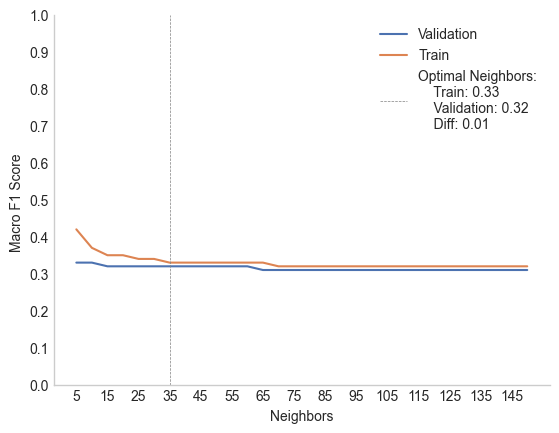

In [32]:
estimate_knn = get_results(estimate_knn_gs, {"model__n_neighbors": "neighbors"})

train_score_35 = estimate_knn.loc[
    estimate_knn["neighbors"] == 35, "mean_train_score"
].values[0]
test_score_35 = estimate_knn.loc[
    estimate_knn["neighbors"] == 35, "mean_test_score"
].values[0]
score_difference = abs(train_score_35 - test_score_35)


sns.lineplot(
    x="neighbors",
    y="mean_test_score",
    data=estimate_knn,
    label="Validation",
)
sns.lineplot(x="neighbors", y="mean_train_score", data=estimate_knn, label="Train")
plt.axvline(
    x=35,
    color="gray",
    linestyle="--",
    label=f"Optimal Neighbors:\n    Train: {train_score_35:.2f}\n    Validation: {test_score_35:.2f}\n    Diff: {score_difference:.2f}",
    linewidth=0.5,
)
plt.xticks(np.arange(5, 155, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Macro F1 Score ")
plt.xlabel("Neighbors")
plt.legend()
plt.show()

In [33]:
num_pipeline.fit_transform(X[num_cols])

,0,1,2,3,4,5,6,7
0,31.0,0.00,1988.0,2.0,2.0,237.0,1.0,27.0
1,46.0,1745.93,1973.0,2.0,52.5,237.0,57.5,27.0
2,40.0,1434.80,1979.0,2.0,26.0,237.0,26.0,27.0
3,61.0,0.00,1958.0,2.0,2.0,237.0,1.0,27.0
4,67.0,0.00,1952.0,2.0,6.0,237.0,5.0,27.0
...,...,...,...,...,...,...,...,...
574021,35.0,0.00,1987.0,2.0,16.0,237.0,16.0,27.0
574022,33.0,0.00,1989.0,2.0,16.0,237.0,16.0,27.0
574023,61.0,991.08,1961.0,2.0,18.0,237.0,18.0,27.0
574024,24.0,0.00,1998.0,2.0,17.0,237.0,17.0,27.0


In [36]:
run = False

if run:

    start_time = time.time()

    pipeline = Pipeline(
        [
            ("preprocessing", None),
            (
                "feature_selection",
                SelectPercentile(
                    score_func=custom_mutual_info_classif, percentile=None
                ),
            ),
            ("model", None),
        ]
    )


    param_grid = [
        # Logistic Regression
        {
            "model": [LogisticRegression(max_iter=1000)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # Decision Tree
        {
            "model": [DecisionTreeClassifier(max_depth=20)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # K-Nearest Neighbors
        {
            "model": [KNeighborsClassifier(n_neighbors=35)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # Gaussian Naive Bayes
        {
            "model": [GaussianNB()],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # MLP Classifier
        {
            "model": [MLPClassifier((20, 20), learning_rate_init=0.01, max_iter=1000)],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
        # Support Vector Classifier
        {
            "model": [SVC(kernel="linear")],
            "preprocessing": [baseline],
            "feature_selection__percentile": [50, 90, 70],
        },
    ]


    gs = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
    )


    gs.fit(X, y)
    dump(gs, "./runs/base_models.joblib")

    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    notify(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

else:
    base_models_gs = load("./runs/base_models.joblib")

In [ ]:
base_models_df = get_results(
    base_models_gs, {"feature_selection__percentile": "FS Percentile"}
)
base_models_df.sort_values(by="mean_test_score", ascending=False)

,model,preprocessing,mean_fit_time,std_fit_time,mean_train_score,std_train_score,mean_test_score,std_test_score,FS Percentile
4,DecisionTreeClassifier,baseline,208.12,1.71,0.77,0.01,0.35,0.01,90
5,DecisionTreeClassifier,baseline,207.70,2.89,0.77,0.01,0.35,0.01,70
3,DecisionTreeClassifier,baseline,202.85,3.03,0.75,0.02,0.34,0.01,50
13,MLPClassifier,baseline,312.96,13.84,0.34,0.00,0.33,0.00,90
6,KNeighborsClassifier,baseline,201.45,8.30,0.34,0.00,0.32,0.00,50
7,KNeighborsClassifier,baseline,211.64,1.37,0.33,0.00,0.32,0.00,90
8,KNeighborsClassifier,baseline,208.83,4.67,0.33,0.00,0.32,0.00,70
14,MLPClassifier,baseline,310.61,34.48,0.33,0.01,0.32,0.01,70
12,MLPClassifier,baseline,365.63,45.56,0.33,0.01,0.32,0.00,50
9,GaussianNB,baseline,211.31,0.33,0.31,0.02,0.30,0.02,50


In [ ]:
from sklearn.metrics import classification_report

y_pred = base_models_gs.best_estimator_.predict(X)
report_dict = classification_report(y, y_pred, zero_division=1, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)
report_df

,precision,recall,f1-score,support
1. CANCELLED,0.67,0.45,0.54,12477.00
2. NON-COMP,0.82,0.98,0.90,291078.00
3. MED ONLY,0.45,0.03,0.06,68906.00
4. TEMPORARY,0.71,0.85,0.77,148507.00
5. PPD SCH LOSS,0.64,0.49,0.56,48280.00
6. PPD NSL,0.87,0.00,0.01,4211.00
7. PTD,1.00,0.00,0.00,97.00
8. DEATH,0.72,0.06,0.11,470.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.73,0.36,0.37,574026.00


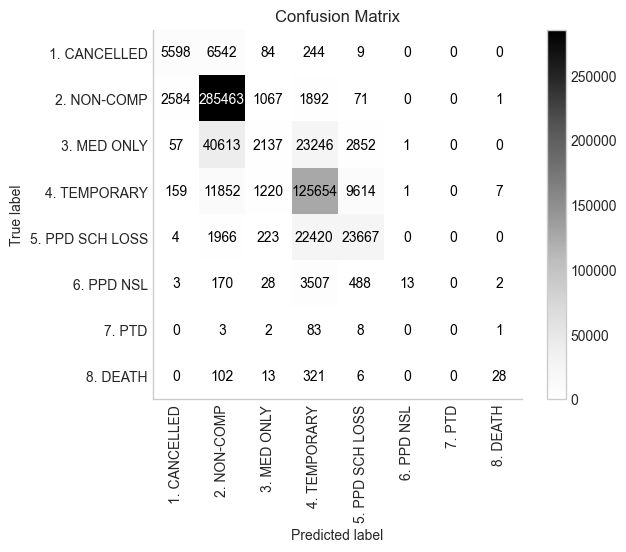

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_pred = base_models_gs.best_estimator_.predict(X)
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=base_models_gs.best_estimator_.classes_
)
disp.plot(cmap="Greys")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

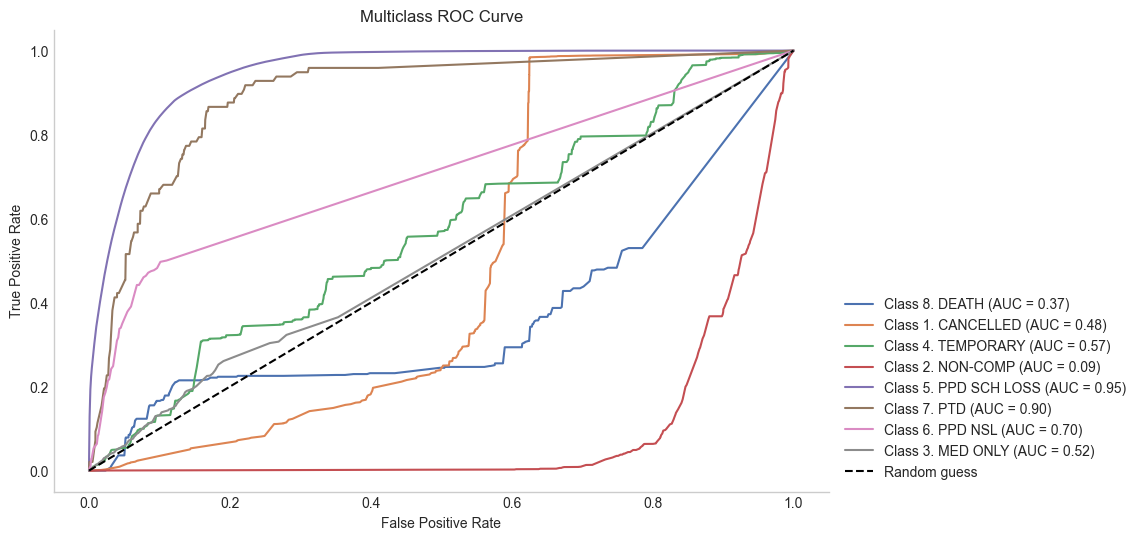

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


best_model = base_models_gs.best_estimator_
# Binarize the labels for one-vs-rest ROC computation
classes = list(set(y))  # Replace with actual class labels if needed
y_test_binarized = label_binarize(y, classes=classes)

# Predict probabilities for each class
y_pred_proba = best_model.predict_proba(X)

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right", bbox_to_anchor=(1.4, 0.0))
plt.show()

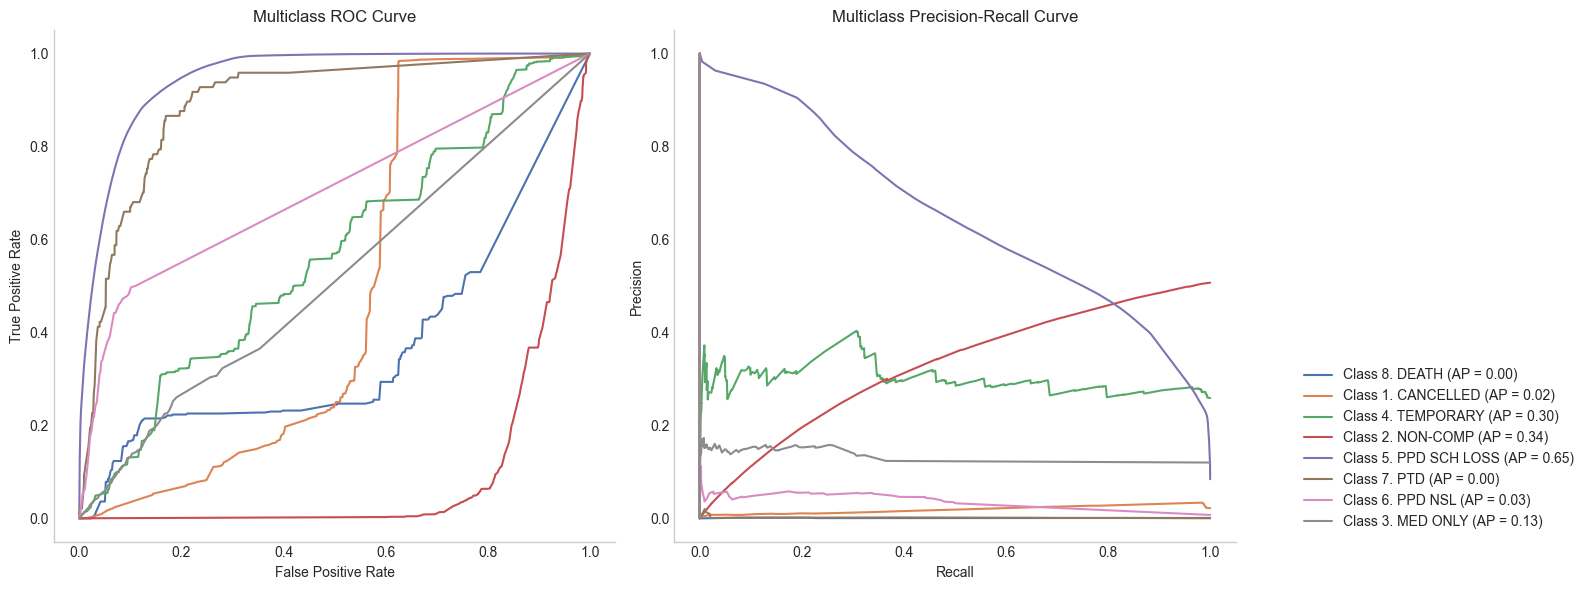

In [76]:
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming best_model, X, y are already defined
best_model = base_models_gs.best_estimator_
classes = list(set(y))  # Replace with actual class labels if needed
y_test_binarized = label_binarize(y, classes=classes)

# Predict probabilities for each class
y_pred_proba = best_model.predict_proba(X)

# Plot ROC and Precision-Recall curves side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax = axes[0]
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")


ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Multiclass ROC Curve")


# Precision-Recall Curve
ax = axes[1]
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_binarized[:, i], y_pred_proba[:, i]
    )
    avg_precision = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    ax.plot(recall, precision, label=f"Class {class_label} (AP = {avg_precision:.2f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Multiclass Precision-Recall Curve")
ax.legend(loc="lower left", bbox_to_anchor=(1.1, 0.0))

plt.tight_layout()
plt.show()

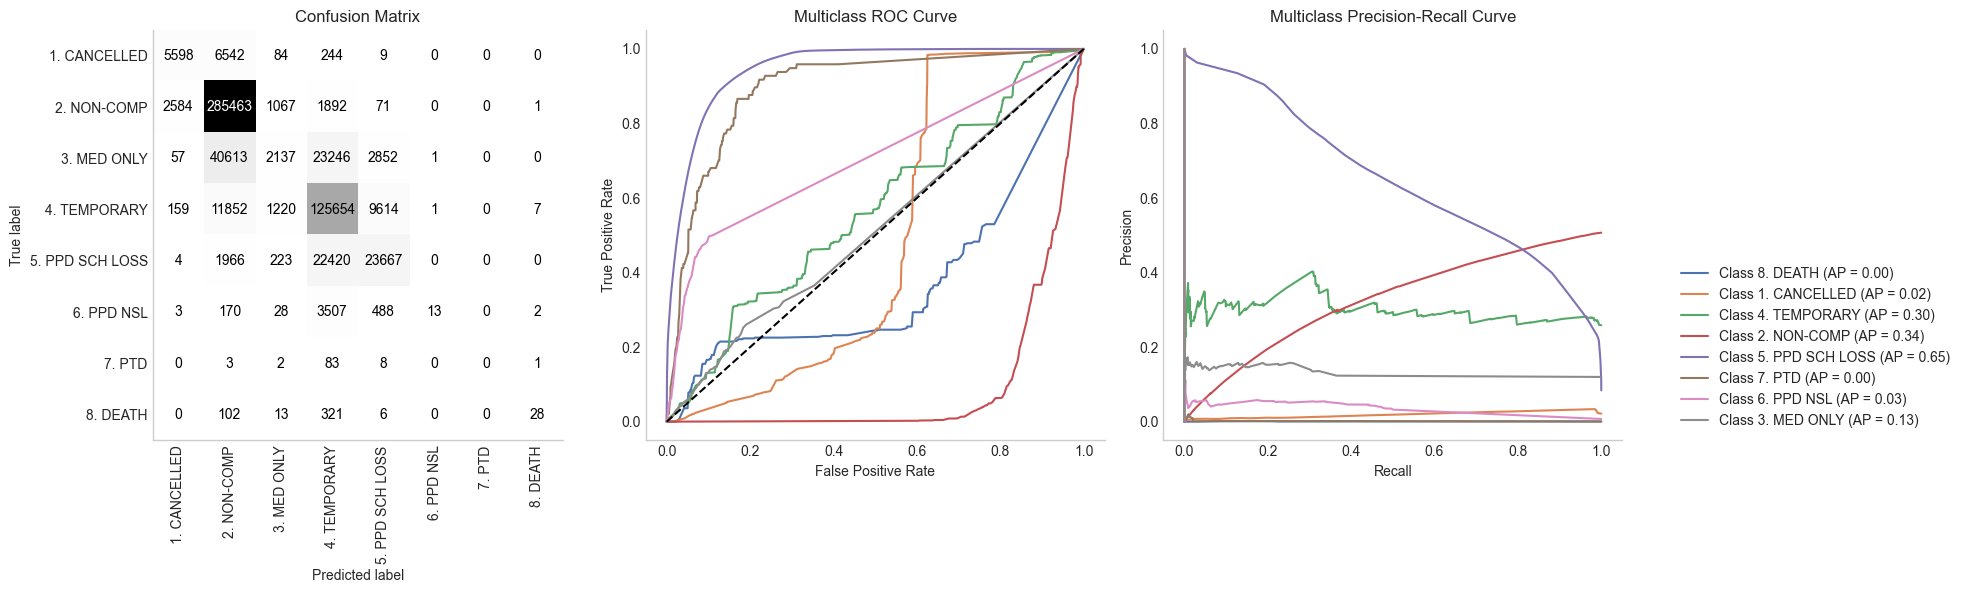

In [82]:
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming best_model, X, y are already defined
best_model = base_models_gs.best_estimator_
classes = list(set(y))  # Replace with actual class labels if needed
y_test_binarized = label_binarize(y, classes=classes)

# Predict probabilities for each class
y_pred_proba = best_model.predict_proba(X)
# Predict labels
y_pred = best_model.predict(X)

# Confusion Matrix
cm = confusion_matrix(y, y_pred)

# Plot Confusion Matrix, ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Confusion Matrix
ax = axes[0]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Greys", ax=ax, colorbar=False)
ax.set_title("Confusion Matrix")
ax.tick_params(axis="x", rotation=90)

# ROC Curve
ax = axes[1]
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Random guess")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Multiclass ROC Curve")

# Precision-Recall Curve
ax = axes[2]
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_binarized[:, i], y_pred_proba[:, i]
    )
    avg_precision = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    ax.plot(recall, precision, label=f"Class {class_label} (AP = {avg_precision:.2f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Multiclass Precision-Recall Curve")
ax.legend(loc="lower left", bbox_to_anchor=(1.1, 0.0))

plt.tight_layout()
plt.show()

In [121]:
import time

start_time = time.time()
for i in range(100000):
    pass
end_time = time.time()

execution_time = end_time - start_time

hours, remainder = divmod(execution_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Execution completed in {int(hours)}:{int(minutes)}:{round(seconds)}")

Execution completed in 0:0:0


# TRASH

In [40]:
X_test = baseline.fit_transform(X)

model = MLPClassifier(
    hidden_layer_sizes=(30, 20, 10), learning_rate_init=0.01, max_iter=1000
)
model.fit(X_test, y)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(hidden_layer_sizes=(30, 20, 10), learning_rate_init=0.01,
              max_iter=1000)

In [55]:
X_background = shap.sample(X_test, 10)
explainer = shap.KernelExplainer(model.predict_proba, X_background)

In [56]:
explainer.shap_values(X_test, gc_collect=True)

  0%|          | 0/574025 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Working Version with placeholder FS

In [ ]:
# pipeline = Pipeline(
#     [
#         ("preprocessing", None),
#         ("feature_selection", SelectFromModel(LogisticRegression(max_iter=1000))),
#         ("model", None),
#     ]
# )

# param_grid = [
#     {
#         "model": [LogisticRegression(max_iter=1000)],
#         "model__C": [0.1, 1],
#         "model__solver": ["lbfgs"],
#         "preprocessing": [base, treatment_1],
#     },
#     {
#         "model": [DecisionTreeClassifier()],
#         "model__max_depth": [3, 5],
#         "model__criterion": ["gini"],
#         "preprocessing": [base, treatment_1],
#     },
# ]

# gs = GridSearchCV(
#     pipeline,
#     param_grid=param_grid,
#     scoring="f1_macro",
#     cv=2,
#     verbose=1,
#     return_train_score=True,
# )
# y = y.to_numpy().ravel()
# gs.fit(X, y)

# # dump(gs, "grid_search.joblib")

In [ ]:
def get_results(gs, round=2):
    results = {
        key: gs.cv_results_[key]
        for key in [
            "mean_fit_time",
            "std_fit_time",
            "mean_train_score",
            "std_train_score",
            "mean_test_score",
            "std_test_score",
            "params",
        ]
    }
    results_df = pd.DataFrame(
        {
            "model": [type(params["model"]).__name__ for params in results["params"]],
            "preprocessing": [
                getattr(params["preprocessing"], "name") for params in results["params"]
            ],
            **results,
        }
    )

    return results_df.round(round)

In [ ]:
get_results(gs)

In [ ]:
import seaborn as sns

sns.barplot(x="model", y="mean_test_score", hue="preprocessing", data=get_results(gs))

In [ ]:
# y_test_pred = gs.best_estimator_.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, classification_report
import time

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = {}
features = {}
classification_reports = {}
times = {}

for fold_num, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    y_train = y_train.squeeze()
    begin = time.perf_counter()
    # Fit the pipeline
    pipefinal.fit(X_train, y_train)
    end = time.perf_counter()
    # Predict and calculate F1 score
    y_pred_train = pipefinal.predict(X_train)
    y_pred_val = pipefinal.predict(X_val)
    score_train = f1_score(y_train, y_pred_train, average="macro")
    score_val = f1_score(y_val, y_pred_val, average="macro")
    scores[fold_num] = [score_train, score_val]

    # Save classification reports
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_val = classification_report(y_val, y_pred_val, output_dict=True)
    classification_reports[fold_num] = {
        "train": report_train,
        "val": report_val,
    }

    # Extract selected features from RFECV
    selected_features = X.columns[pipefinal.named_steps["feature_selection"].support_]
    features[fold_num] = list(selected_features)
    times[fold_num] = end - begin
# Print results
for fold in scores.keys():
    print(
        f"Fold {fold}: F1 score (train, val) = {scores[fold]}, Selected features = {features[fold]}"
    )
    print(f"Classification report for fold {fold} (train):")
    print(classification_reports[fold]["train"])
    print(f"Classification report for fold {fold} (validation):")
    print(classification_reports[fold]["val"])
    print(f"Time for fold {fold}: {times[fold]}")

In [ ]:
pipefinal.fit(X_train, y_train_encoded)

In [ ]:
pipefinal.score(X_train, y_train_encoded)

In [ ]:
y_val_encoded = label_encoder.fit_transform(y_val)

In [ ]:
pipefinal.score(X_val, y_val_encoded)

In [ ]:
test_df = pd.read_csv("./resources/test_data.csv")
test_df.set_index("Claim Identifier", inplace=True)

In [ ]:
# Treating binary variables

# Convert Attorney/Representative to binary representation
test_df["Alternative Dispute Resolution"] = test_df[
    "Alternative Dispute Resolution"
].map({"Y": 1, "N": 0, "U": np.nan})

# Convert Attorney/Representative to binary representation
test_df["Attorney/Representative"] = test_df["Attorney/Representative"].map(
    {"Y": 1, "N": 0}
)

# Convert COVID-19 Indicator to binary representation
test_df["COVID-19 Indicator"] = test_df["COVID-19 Indicator"].map({"Y": 1, "N": 0})

# Create a binary variable for the male gender
test_df["Male"] = np.select(
    [
        test_df["Gender"] == "M",
        test_df["Gender"] == "F",
        test_df["Gender"] == "X",
        test_df["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

In [ ]:
test_df["Accident Date"] = pd.to_datetime(test_df["Accident Date"])
test_df["Assembly Date"] = pd.to_datetime(test_df["Assembly Date"])
test_df["C-2 Date"] = pd.to_datetime(test_df["C-2 Date"])
test_df["First Hearing Date"] = pd.to_datetime(test_df["First Hearing Date"])

test_df["Accident to Assembly Days"] = (
    test_df["Assembly Date"] - test_df["Accident Date"]
).dt.days
test_df["Accident to First Hearing Days"] = (
    test_df["First Hearing Date"] - test_df["Accident Date"]
).dt.days
test_df["Accident to C-2 Days"] = (
    test_df["C-2 Date"] - test_df["Accident Date"]
).dt.days

In [ ]:
# I. Burn or Scald - Heat or Cold Exposures - Contact With
burn_or_scald = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "11", "14", "84"]

# II. Caught In, Under or Between
caught_in_under_between = ["10", "12", "13", "20"]

# III. Cut, Puncture, Scrape Injured By
cut_puncture_scrape = ["15", "16", "17", "18", "19"]

# IV. Fall, Slip or Trip Injury
fall_slip_trip = ["25", "26", "27", "28", "29", "30", "31", "32", "33"]

# V. Motor Vehicle
motor_vehicle = ["40", "41", "45", "46", "47", "48", "50"]

# VI. Strain or Injury By
strain_or_injury = ["52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "97"]

# VII. Striking Against or Stepping On
striking_against = ["65", "66", "67", "68", "69", "70"]

# VIII. Struck or Injured By
struck_or_injured = ["74", "75", "76", "77", "78", "79", "80", "81", "85", "86"]

# IX. Rubbed or Abraded By
rubbed_or_abraded = ["94", "95"]

# X. Miscellaneous Causes
miscellaneous = ["82", "83", "87", "88", "89", "90", "91", "93", "96", "98", "99"]


test_df["WCIO Cause of Injury Code SUPRA"] = test_df["WCIO Cause of Injury Code"].apply(
    lambda code: (
        "I. Burn or Scald - Heat or Cold Exposures - Contact With"
        if str(code).split(".")[0] in burn_or_scald
        else (
            "II. Caught In, Under or Between"
            if str(code).split(".")[0] in caught_in_under_between
            else (
                "III. Cut, Puncture, Scrape Injured By"
                if str(code).split(".")[0] in cut_puncture_scrape
                else (
                    "IV. Fall, Slip or Trip Injury"
                    if str(code).split(".")[0] in fall_slip_trip
                    else (
                        "V. Motor Vehicle"
                        if str(code).split(".")[0] in motor_vehicle
                        else (
                            "VI. Strain or Injury By"
                            if str(code).split(".")[0] in strain_or_injury
                            else (
                                "VII. Striking Against or Stepping On"
                                if str(code).split(".")[0] in striking_against
                                else (
                                    "VIII. Struck or Injured By"
                                    if str(code).split(".")[0] in struck_or_injured
                                    else (
                                        "IX. Rubbed or Abraded By"
                                        if str(code).split(".")[0] in rubbed_or_abraded
                                        else (
                                            "X. Miscellaneous Causes"
                                            if str(code).split(".")[0] in miscellaneous
                                            else np.nan
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [ ]:
# Specific Injury codes (Category I)
specific_injury = [
    "1",
    "2",
    "3",
    "4",
    "7",
    "10",
    "13",
    "16",
    "19",
    "22",
    "25",
    "28",
    "30",
    "31",
    "32",
    "34",
    "36",
    "37",
    "38",
    "40",
    "41",
    "42",
    "43",
    "46",
    "47",
    "49",
    "52",
    "53",
    "54",
    "55",
    "58",
    "59",
]

# Occupational Disease or Cumulative Injury codes (Category II)
occupational_disease = [
    "60",
    "61",
    "62",
    "63",
    "64",
    "65",
    "66",
    "67",
    "68",
    "69",
    "70",
    "71",
    "72",
    "73",
    "74",
    "75",
    "76",
    "77",
    "78",
    "79",
    "80",
    "83",
]

# Multiple Injuries codes (Category III)
multiple_injuries = ["90", "91"]


test_df["WCIO Nature of Injury Code SUPRA"] = test_df[
    "WCIO Nature of Injury Code"
].apply(
    lambda code: (
        "Category I: Specific Injury"
        if str(code).split(".")[0] in specific_injury
        else (
            "Category II: Occupational Disease or Cumulative Injury"
            if str(code).split(".")[0] in occupational_disease
            else (
                "Category III: Multiple Injuries"
                if str(code).split(".")[0] in multiple_injuries
                else np.nan
            )
        )
    )
)

In [ ]:
# I. Head
head = [
    "10",
    "11",
    "12",
    "13",
    "13A",
    "13B",
    "13C",
    "14",
    "14A",
    "14B",
    "14C",
    "15",
    "16",
    "17",
    "18",
    "19",
]

# II. Neck
neck = ["20", "21", "22", "23", "24", "25", "26"]

# III. Upper Extremities
upper_extremities = [
    "30",
    "31",
    "32",
    "33",
    "34",
    "35",
    "36",
    "36A",
    "36B",
    "36C",
    "36D",
    "36E",
    "36F",
    "36G",
    "36H",
    "36I",
    "36J",
    "36K",
    "36L",
    "36M",
    "36N",
    "36O",
    "36P",
    "37",
    "37A",
    "37B",
    "37C",
    "38",
    "39",
]

# IV. Trunk
trunk = [
    "40",
    "41",
    "42",
    "43",
    "44",
    "45",
    "46",
    "47",
    "48",
    "49",
    "60",
    "61",
    "62",
    "63",
]

# V. Lower Extremities
lower_extremities = [
    "50",
    "51",
    "52",
    "53",
    "54",
    "55",
    "56",
    "57",
    "57A",
    "57B",
    "57C",
    "57D",
    "57E",
    "57F",
    "57G",
    "58",
    "58A",
    "58B",
    "58C",
]

# VI. Multiple Body Parts
multiple_body_parts = ["64", "65", "66", "90", "91", "99"]


test_df["WCIO Part Of Body Code SUPRA"] = test_df["WCIO Part Of Body Code"].apply(
    lambda code: (
        "I. Head"
        if str(code).split(".")[0] in head
        else (
            "II. Neck"
            if str(code).split(".")[0] in neck
            else (
                "III. Upper Extremities"
                if str(code).split(".")[0] in upper_extremities
                else (
                    "IV. Trunk"
                    if str(code).split(".")[0] in trunk
                    else (
                        "V. Lower Extremities"
                        if str(code).split(".")[0] in lower_extremities
                        else (
                            "VI. Multiple Body Parts"
                            if str(code).split(".")[0] in multiple_body_parts
                            else np.nan
                        )
                    )
                )
            )
        )
    )
)

In [ ]:
predictions_test1 = pipefinal.predict(test_df)

In [ ]:
predictions_test2 = label_encoder.inverse_transform(predictions_test1)

In [ ]:
predictions = pd.DataFrame(test_df.index)
predictions["Claim Injury Type"] = predictions_test2
predictions.to_csv("predictions_pipeline.csv", index=False)